# Select the outlet of a basin from a DEM shown in an interactive map 

Marina Ruiz Sanchez-Oro 
24/06/2022

In [ ]:
# Code to process large amounts of basins from different DEMs

In [14]:
import numpy as np
import pandas as pd
import os 
import folium
from folium import plugins
import rioxarray as rxr
import rasterio
import earthpy as et
import earthpy.spatial as es
import rasterio.warp
from rasterio.crs import CRS
from shapely.geometry import box
import re

Load the DEM 

In [1]:
!pwd

/exports/csce/datastore/geos/users/s1440040/LSDTopoTools/data/ExampleTopoDatasets/ChiAnalysisData


In [ ]:
# the idea would be to have a whole list of DEM paths here 
base_path = '/exports/csce/datastore/geos/users/s1440040/LSDTopoTools/data/ExampleTopoDatasets/ChiAnalysisData/dems_to_process'
DEM_paths = [base_path+'andes/', base_path_path+'pyrenees']# complete the list later - first try with just two cases
DEM_names = ['andes_north_dem.bil', 'dem_basin.bil']

In [ ]:
for i in range(len(DEM_names)):
    my_dem = DEM_paths[i]+DEM_names[i]
    

In [42]:
#my_dem_path = './Andes/andes_north_results/input_data/andes_north_dem.bil'
my_dem_path = './Massif_central/dem_tiny_basin.bil'
my_dem = rasterio.open(my_dem_path)

Select the extent of the DEM 

In [43]:
map_bounds = my_dem.bounds
xmin, ymin, xmax, ymax  = map_bounds[0], map_bounds[1], map_bounds[2], map_bounds[3]

In [44]:
# get the crs of the source DEM - isolate the EPSG number
dem_crs = str(my_dem.crs)
dem_crs = re.split('(\d+)',dem_crs)


In [45]:
# Project the DEM to the desired CRS
feature_proj = rasterio.warp.transform_geom(
    CRS.from_epsg(dem_crs[1]),
    CRS.from_epsg(4326),
    box(*map_bounds)
)

In [46]:
# Open the raster in rioxarray
img = rxr.open_rasterio(my_dem_path, masked=True)

# Replace all null values with the minimum value in the array
img_plot = img.where(~img.isnull(), img.min())

# Scale the array from 0 to 255
scaled_img = es.bytescale(img_plot.values[0])

In [47]:
# get the bounds of the raster in the new coordinate system (EPSG:4326)
xmin = feature_proj['coordinates'][0][0][0]
ymin = feature_proj['coordinates'][0][0][1]
xmax = feature_proj['coordinates'][0][2][0] 
ymax = feature_proj['coordinates'][0][2][1]

In [ ]:
# Display map 

# Center the map at the coordinates lat_center, lon_center
lat_center = ((ymin)+(ymax))/2
lon_center = ((xmin)+(xmax))/2

# Create a map using Stamen Terrain, centered on study area with set zoom level
m = folium.Map(location=[lat_center, lon_center], tiles ='Stamen Terrain')

map_bounds = [[ymin, xmin], 
              [ymax,xmax]]
# # Overlay raster called img using add_child() function (opacity and bounding box set)
m.add_child(folium.raster_layers.ImageOverlay(scaled_img,opacity=0.5,
                                              bounds=map_bounds))
m.add_child(folium.LatLngPopup())

# Display map 
m


In [20]:
# here the lat, lon need to be selected by clicking on the map and copying/pasting the results because I cannot
# find a way to automatically save the coordinates by just clicking on the map. 

lat_outlet = 44.0602
lon_outlet = 3.9830
latlon_dict = {'Latitude': lat_outlet, 'Longitude': lon_outlet}

In [21]:
# create a csv file with the lat lon values
# give a descriptive name for the area - this will need to be the same name as the name of your raster area
area_name = 'massif_central'
csv_path = './'
csv_name = f'{area_name}_outlet_csv_latlon.csv'

df = pd.DataFrame.from_dict(latlon_dict, orient="index")
df = df.transpose()

df.to_csv(csv_path+csv_name, index=None)

In [1]:
import lsdtopytools as lsd
dem_basins_with_rain = lsd.LSDDEM(path = './Massif_central/',file_name = "dem_tiny_basin.bil")
dem_basins_with_rain.PreProcessing(filling = True, carving = True, minimum_slope_for_filling = 0.0001)

Loading the raster from file: ./Massif_central/dem_tiny_basin.bil
LOADING TOOK 0.07766985893249512
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.003976583480834961
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.023233890533447266
FINALISATION TOOK 0.0002486705780029297
lsdtopytools is now ready to roll!
Carving: implementation of Lindsay (2016) DOI: 10.1002/hyp.10648
Filling: implementation of Wang and Liu (2006): https://doi.org/10.1080/13658810500433453
Processing...
DEM ready for flow routines!


In [2]:
dem_basins_with_rain.CommonFlowRoutines(discharge = False)

Processing common flow routines...
Done!


In [66]:
# min_area = 1e9 without precipitation
# min_area = 8e8 with precipitation
dem_basins_with_rain.ExtractRiverNetwork(method = "area_threshold", area_threshold_min = 150000)
XY_basins_with_rain = dem_basins_with_rain.DefineCatchment(method="min_area", test_edges = False, min_area = 1e8,max_area = 1e20, X_coords = [], Y_coords = [], 
	 coord_search_radius_nodes = 30, coord_threshold_stream_order = 3)
dem_basins_with_rain.GenerateChi(theta=0.45,A_0 = 1)

In [67]:
df = dem_basins_with_rain.df_base_river
# transform the coordinates from the base river into WGS84 EPSG:4326
df.rename(columns={"x": "Longitude", "y": "Latitude"},inplace=True)

In [69]:
from osgeo import ogr, osr

def generate_coordinates(lon, lat, in_crs, out_crs):
    lon_transformed, lat_tranformed = coordinate_transform(in_crs, out_crs, float(lon), float(lat))
    return lon_transformed, lat_tranformed

def coordinate_transform(in_src, out_src, lon,lat): # in_src ,out_src only take the number 
    InSR = osr.SpatialReference()
    InSR.ImportFromEPSG(in_src)       # WGS84/Geographic
    OutSR = osr.SpatialReference()
    OutSR.ImportFromEPSG(out_src)     # WGS84 UTM Zone 56 South

    Point = ogr.Geometry(ogr.wkbPoint)
    Point.AddPoint(lon,lat) # use your coordinates here
    Point.AssignSpatialReference(InSR)    # tell the point what coordinates it's in
    Point.TransformTo(OutSR)              # project it to the out spatial reference
    #print(f'lon: {Point.GetX()}, lat: {Point.GetY()}') # output projected X and Y coordinates
    return Point.GetX(),Point.GetY()

In [70]:

df['lon_4326'], df['lat_4326'] = zip(*df.apply(lambda row : generate_coordinates(row['Longitude'],row['Latitude'], int(dem_crs[1]), 4326), axis = 1))
df_copy = df.copy()
df_copy.drop(df_copy.columns.difference(['lon_4326','lat_4326']), 1, inplace=True)
df_copy.rename(columns={"lon_4326": "longitude", "lat_4326": "latitude"},inplace=True)

<ipython-input-70-a7f8d332ae11>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_copy.drop(df_copy.columns.difference(['lon_4326','lat_4326']), 1, inplace=True)


In [71]:
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.longitude, point.latitude],
                        radius=2,
                        weight=5).add_to(m)


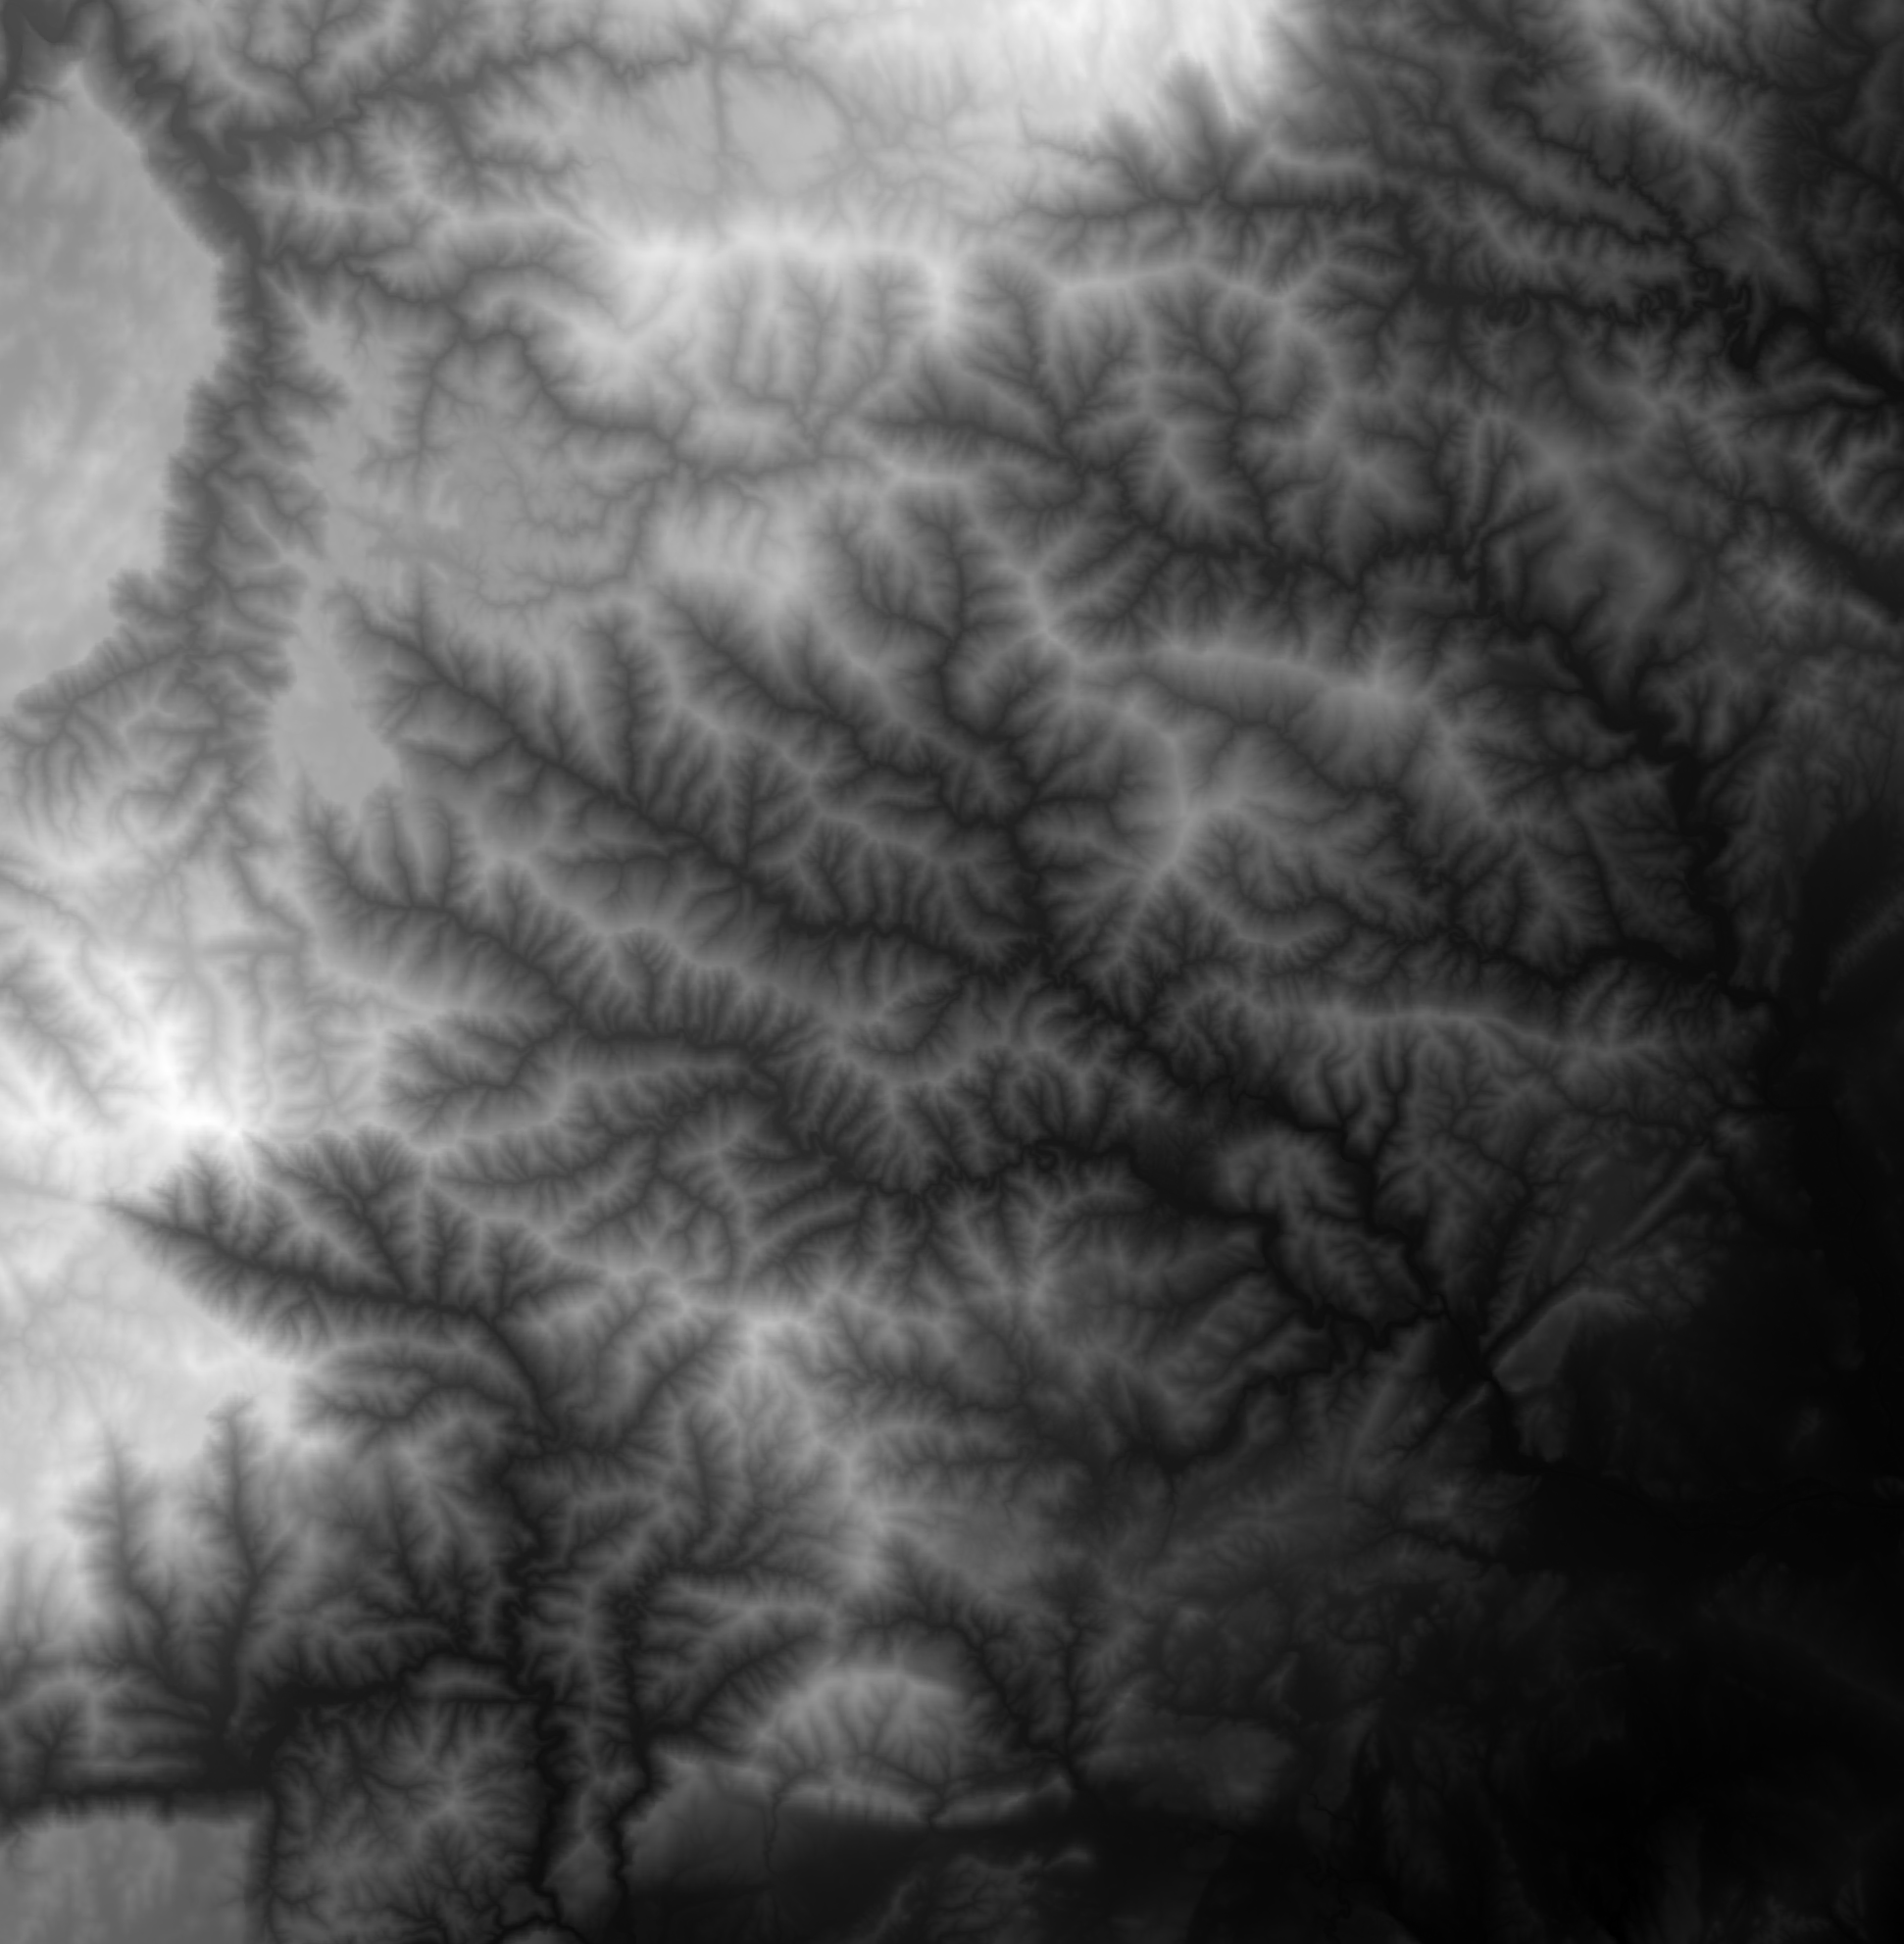

In [77]:
import folium
import pandas as pd

#create a map
#this_map = folium.Map(prefer_canvas=True)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
#dummy_copy.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
#this_map.fit_bounds(this_map.get_bounds())
#this_map


# Display map 

# Center the map at the coordinates lat_center, lon_center
lat_center = ((ymin)+(ymax))/2
lon_center = ((xmin)+(xmax))/2

# Create a map using Stamen Terrain, centered on study area with set zoom level
m = folium.Map(location=[lat_center, lon_center], tiles ='Stamen Terrain')

map_bounds = [[ymin, xmin], 
              [ymax,xmax]]
# # Overlay raster called img using add_child() function (opacity and bounding box set)

df_copy.apply(plotDot, axis = 1)

m.add_child(folium.raster_layers.ImageOverlay(scaled_img,opacity=0.5,
                                              bounds=map_bounds))
m.add_child(folium.LatLngPopup())

# Display map 
m




In [ ]:
Latitude: 44.0682
Longitude: 3.9762

In [75]:
# here the lat, lon need to be selected by clicking on the map and copying/pasting the results because I cannot
# find a way to automatically save the coordinates by just clicking on the map. 

lat_outlet = 44.0682
lon_outlet = 3.9762
latlon_dict = {'Latitude': lat_outlet, 'Longitude': lon_outlet}

In [76]:
# create a csv file with the lat lon values
# give a descriptive name for the area - this will need to be the same name as the name of your raster area
area_name = 'massif_central'
csv_path = './'
csv_name = f'{area_name}_outlet_csv_latlon.csv'

df = pd.DataFrame.from_dict(latlon_dict, orient="index")
df = df.transpose()

df.to_csv(csv_path+csv_name, index=None)